# Community detection in the Imperial College NetFlow graph

Import `lsbm` library:

In [1]:
import lsbm

Import data:

In [2]:
import numpy as np
## Load data
X = np.load('../data/X_icl2.npy')[:,:5]
lab = np.loadtxt('../data/labs2.csv', dtype=int)
d = X.shape[1]

Define initial number of clusters:

In [3]:
K = 4

Define latent basis functions:

In [4]:
first_linear = [True]
## Define latent functions
fW = {}
fW[0,0] = lambda x: np.array([x])
for j in range(1,5):
    fW[0,j] = lambda x: np.array([x ** 2, x])

Define `lsbm` model object:

In [5]:
m = lsbm.lsbm_gibbs(X=X, K=4, W_function=fW, K_fixed=False, first_linear=first_linear)

Initialise cluster allocations using $k$-means:

In [6]:
np.random.seed(11711)
from sklearn.cluster import KMeans
m.initialise(z=KMeans(n_clusters=m.K).fit_predict(m.X), theta=X[:,0]+np.random.normal(size=m.n,scale=0.01), 
                            Lambda_0=(1/m.n)**2, mu_theta=X[:,0].mean(), sigma_theta=1, b_0=0.001)

Run MCMC: 

In [7]:
np.random.seed(11711)
q = m.mcmc(samples=50000, burn=5000, chains=1, store_chains=True, q=100, thinning=1, sigma_prop=0.01)

Chain: 1 / 1 	Burnin: 5000 / 5000 	Samples: 50000 / 50000


Save output:

In [8]:
np.save('../ICL/out_theta_quad_randomK.npy',q[0])
np.save('../ICL/out_z_quad_randomK.npy',q[1])

Plot number of communities:

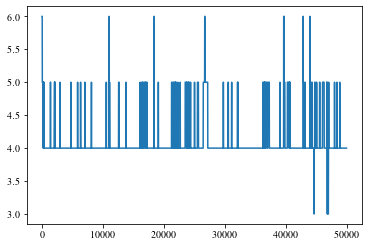

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.plot(np.apply_along_axis(func1d=lambda x: len(np.unique(x)), axis=0, arr=q[1][:,0]))
plt.show()

Estimate and plot clusters:

In [14]:
import estimate_cluster
psm = np.zeros((m.n,m.n))
for z in q[1][:,0].T:
    psm += np.equal.outer(z,z)
psm /= q[1].shape[2]
z_est = estimate_cluster.estimate_clustering(psm, k=4)

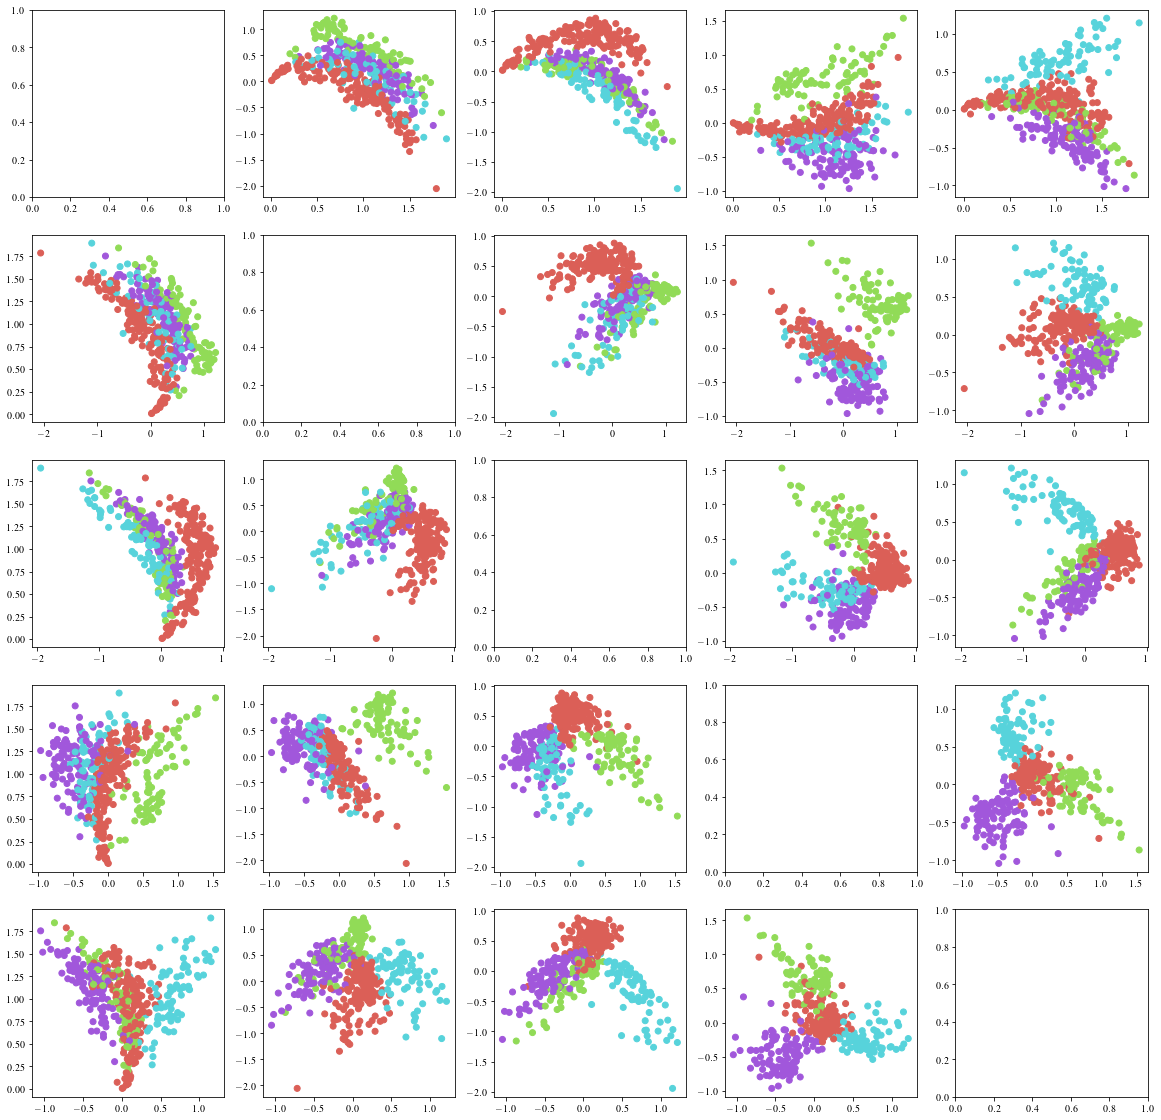

In [15]:
plt.rcParams['figure.figsize'] = [20, 20]
import seaborn as sns
zcol = [sns.color_palette("hls", 4)[z] for z in z_est]
fig, axs = plt.subplots(m.d,m.d)
for k in range(m.d):
    for h in range(m.d):
        if k != h:
            axs[k,h].scatter(m.X[:,k],m.X[:,h],c=zcol)
plt.show()

Calculate ARI for estimated clustering:

In [16]:
from sklearn.metrics import adjusted_rand_score as ari
ari(z_est, lab)

0.9402354616112392

Histogram of K:

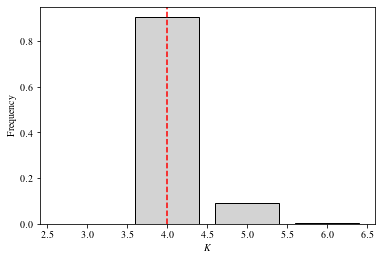

In [17]:
from collections import Counter
plt.rcParams['figure.figsize'] = [6, 4]
Kc = Counter(np.apply_along_axis(func1d=lambda x: len(np.unique(x)), axis=0, arr=q[1][:,0]))
Kx = np.array(list(Kc.keys()))
Ky = np.array(list(Kc.values())) / np.sum(np.array(list(Kc.values())))
plt.bar(x=Kx, height=Ky, color='lightgray', edgecolor='black')
plt.axvline(x=4, ls='--', c='red')
plt.xlabel('$K$')
plt.ylabel('Frequency')
plt.savefig('../ICL/icl_full_Khist.pdf',bbox_inches='tight')
plt.show()